In [5]:
import os
import glob
import yaml
import fitsio
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import astropy.io.fits as fits

from   desitarget.sv1.sv1_targetmask import desi_mask as sv1_desi_mask
from   desitarget.sv1.sv1_targetmask import bgs_mask as sv1_bgs_mask

from   desitarget.targetmask import desi_mask, bgs_mask

from   astropy.table import Table, vstack, join, unique
from   desiutil.dust import mwdust_transmission

##  Generate config files for desispec/scripts/tsnr_ensemble.py

In [1]:
# Define tracer type to be studied. 
# See https://github.com/desihub/desitarget/blob/master/py/desitarget/sv1/data/sv1_targetmask.yaml#L18
# tracer_type = 'ELG_SV_GFIB'
# 
tracer_type   = 'QSO'  # ['BGS_BRIGHT', 'LRG', 'ELG', 'QSO']
outdir        = '/project/projectdirs/desi/users/mjwilson/tsnr/'

In [2]:
# E.g. https://github.com/desihub/desitarget/blob/dd353c6c8dd8b8737e45771ab903ac30584db6db/py/desitarget/cuts.py#L1434
limiting_band = {'BGS': 'r', 'LRG': 'z', 'ELG': 'g', 'QSO': 'r'}

In [6]:
np.random.seed(314)

In [11]:
def imaging_fetch(npix=20, main=True, verbose=True):
    '''
    Return an imaging catalog (random stack of size npix healpixels) of a given type. 
    '''

    if tracer_type.split('_')[0] == 'BGS':
        survey = 'bright'
    else:
        survey = 'dark'
        
    # Fetch the main target catalogues (split by hpx).
    paths=glob.glob('/global/cfs/cdirs/desi/target/catalogs/dr9/0.49.0/targets/main/resolve/{}/targets-{}-hp-*.fits'.format(survey, survey))
            
    if verbose:
        print(len(paths))
            
    # Take a random sample of size hpx, seeded to 314.
    samples = np.random.choice(paths, size=npix, replace=False)    
    catalog = None
    
    # Fetch the hpx in the sample and stack to a catalog.
    for sample in samples:
        dat     = fits.open(sample)[1].data    
    
        if tracer_type.split('_')[0] == 'BGS':
            isin = (dat['DESI_TARGET'] & desi_mask['BGS_ANY']) != 0
            isin = isin & ((dat['BGS_TARGET'] & bgs_mask[tracer_type]) != 0)
        
        else:
            isin = (dat['DESI_TARGET'] & desi_mask[tracer_type]) != 0
        
        if verbose:
            print(os.path.basename(sample), np.count_nonzero(isin))
    
        dat     = Table(dat[isin])
    
        if catalog is None:
            catalog = dat
        else:
            catalog = vstack((catalog, dat))
            
    return catalog

In [14]:
def prod_fetch(prod='blanc', dX2=25., verbose=False):
    '''
    Return a spectroscopic catalog of all deep fields in a given prod. 
    Note:  Adds MW_TRANS*
    '''
    
    sv1_map = {'BGS': 'BGS_BRIGHT', 'LRG': 'LRG_IR', 'ELG': 'ELG_SV_GFIB', 'QSO': 'QSO_RF_4PASS'}
    _tracer_type = sv1_map[tracer_type]
        
    # Fetch the sv1 target catalogues (split by hpx).
    paths=glob.glob('/global/cfs/cdirs/desi/spectro/redux/{}/tiles/*/deep/zbest-*.fits'.format(prod))
    
    if verbose:
        print(len(paths))
    
    catalog = None
    
    # 
    comments = {'80615': 'Missing SV1_DESI_TARGET'}
    ignore   = list(comments.keys())
    
    # Fetch the hpx in the sample and stack to a catalog.
    for sample in paths:
        zbest    = Table.read(sample, 'ZBEST')   
        fmap     = Table.read(sample, 'FIBERMAP')

        tileid   = os.path.basename(sample).split('-')[2]

        if tileid in ignore:
            print('Ignoring {}'.format(tileid))
            continue
        
        dat          = join(zbest, unique(fmap, 'TARGETID'), join_type='left', keys='TARGETID')
    
        try:
            if tracer_type.split('_')[0] == 'BGS':
                isin = (dat['SV1_DESI_TARGET'] & sv1_desi_mask['BGS_ANY']) != 0
                isin = isin & ((dat['SV1_BGS_TARGET'] & sv1_bgs_mask[_tracer_type]) != 0)
        
            else:
                isin = (dat['SV1_DESI_TARGET'] & sv1_desi_mask[_tracer_type]) != 0
    
            isin = isin & (dat['ZWARN'] == 0) & (dat['DELTACHI2'] > dX2)    
            
            if verbose:
                print(os.path.basename(sample), len(dat), np.count_nonzero(isin))
            
            dat      = dat[isin]
            
        except:
            print('Failed on {}'.format(sample))
            
            dat.pprint()
            
            continue

        for band in ['G', 'R', 'Z']:
            dat['MW_TRANSMISSION_{}'.format(band)] = mwdust_transmission(dat['EBV'], band, dat['PHOTSYS'].data.astype(str))
            
        if catalog is None:
            catalog = dat
        else:
            catalog = vstack((catalog, dat))
            
    return  catalog

In [9]:
def reduce(dat, config):
    '''
    Input catalog: dat.    
    '''
    base_type    = tracer_type.split('_')[0]
    lim_band     = limiting_band[base_type].upper() 
    
    drflx        = dat['FLUX_{}'.format(lim_band)] / dat['MW_TRANSMISSION_{}'.format(lim_band)]
    drfibflx     = dat['FIBERFLUX_{}'.format(lim_band)] / dat['MW_TRANSMISSION_{}'.format(lim_band)]
    drmag        = 22.5 - 2.5 * np.log10(drflx)
    drfibmag     = 22.5 - 2.5 * np.log10(drfibflx) 
    
    print('{} Catalog length: {:.1f}M'.format(tracer_type, len(dat) / 1.e6))
    
    if 'med_mag' not in config.keys():
        med_mag      = np.median(drmag)
        med_fibmag   = np.median(drfibmag)
        limiting_mag = np.percentile(drmag, 99.)
    
        print('Median mag. in {} band: {:.2f}'.format(lim_band, med_mag))
        print('Median fib. mag. in {} band: {:.2f}'.format(lim_band, med_fibmag))
        print('Limiting mag. in {} band: {:.2f}'.format(lim_band, limiting_mag))
        
        config['filter'] = 'decam2014-{}'.format(lim_band.lower())
        config['med_mag'] = np.round(med_mag, 3)
        config['limit_mag'] = np.round(limiting_mag, 3)
        
    else:
        med_mag  = np.float64(config['med_mag']) 
        limiting_mag = np.float64(config['limit_mag'])
        
        print('Median mag. in {} band: {:.2f}'.format(lim_band, med_mag))
        print('Limiting mag. in {} band: {:.2f}'.format(lim_band, limiting_mag))
        
    isin         = (drmag > med_mag) & (drmag < limiting_mag)
    
    dat          = dat[isin]
    mtypes, cnts = np.unique(dat['MORPHTYPE'], return_counts=True)

    flosses      = []

    for i, mtype in enumerate(mtypes):
        is_type    = (dat['MORPHTYPE'] == mtype)
        type_floss = np.median(drfibflx[isin][is_type] / drflx[isin][is_type])

        flosses.append(type_floss)
        
        print('{} fiber flux loss: {:.2f} for {:.2f} fraction'.format(mtype, type_floss, cnts[i] / len(dat)))
        
    flosses = np.array(flosses)

    if 'Z' not in dat.dtype.names:
        pl.hist(drmag, bins=100)
        
        pl.axvline(med_mag, c='k', lw=0.4)
        pl.axvline(limiting_mag, c='k', lw=0.4)
        
        floss   = np.average(flosses, weights=cnts)
    
        print('Weighted fiber flux loss: {:.2f}'.format(floss))
        print('Weighted fiber flux loss: {:.2f} mags'.format(-2.5 * np.log10(floss)))
        
        config['fiberloss'] = np.round(-2.5 * np.log10(floss), 3)
    
    else:
        zlo = np.percentile(dat['Z'], 15)
        zhi = np.percentile(dat['Z'], 85)

        config['zlo'] = np.round(zlo, 3)
        config['zhi'] = np.round(zhi, 3)
        
        pl.hist(dat['Z'], bins=200)
            
        pl.axvline(zlo, c='k', lw=0.4)
        pl.axvline(zhi, c='k', lw=0.4)
        
        pl.xlim(0.0, 2.0)

In [12]:
imaging_catalog = imaging_fetch()

460
targets-dark-hp-97.fits 14918
targets-dark-hp-36.fits 2476
targets-dark-hp-732.fits 2614
targets-dark-hp-564.fits 13549
targets-dark-hp-197.fits 16261
targets-dark-hp-539.fits 13754
targets-dark-hp-471.fits 882
targets-dark-hp-293.fits 13626
targets-dark-hp-238.fits 17326
targets-dark-hp-99.fits 14718
targets-dark-hp-517.fits 97707
targets-dark-hp-445.fits 14301
targets-dark-hp-356.fits 1739
targets-dark-hp-116.fits 15849
targets-dark-hp-418.fits 5166
targets-dark-hp-154.fits 15462
targets-dark-hp-352.fits 9431
targets-dark-hp-107.fits 10385
targets-dark-hp-256.fits 8989
targets-dark-hp-148.fits 16404


In [15]:
spec_catalog = prod_fetch()

Ignoring 80615
Ignoring 80615
Ignoring 80615
Ignoring 80615
Ignoring 80615
Ignoring 80615
Ignoring 80615
Ignoring 80615
Ignoring 80615
Ignoring 80615


In [28]:
config = {}

<ipython-input-9-13a24c342b20>:11: RuntimeWarning: divide by zero encountered in log10
  drfibmag     = 22.5 - 2.5 * np.log10(drfibflx)


QSO Catalog length: 0.3M
Median mag. in R band: 21.83
Median fib. mag. in R band: 22.11
Limiting mag. in R band: 22.69
PSF fiber flux loss: 0.78 for 1.00 fraction
Weighted fiber flux loss: 0.78
Weighted fiber flux loss: 0.27 mags


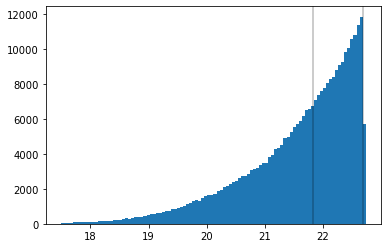

In [29]:
reduce(imaging_catalog, config)

In [30]:
config

{'filter': 'decam2014-r',
 'med_mag': 21.834,
 'limit_mag': 22.691,
 'fiberloss': 0.272}

QSO Catalog length: 0.0M
Median mag. in R band: 21.83
Limiting mag. in R band: 22.69
DEV fiber flux loss: 0.64 for 0.05 fraction
EXP fiber flux loss: 0.70 for 0.02 fraction
PSF fiber flux loss: 0.78 for 0.79 fraction
REX fiber flux loss: 0.70 for 0.15 fraction


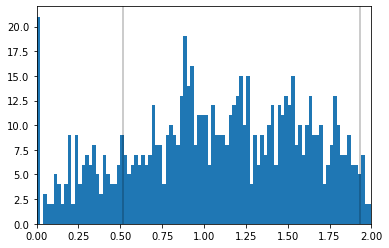

In [31]:
reduce(spec_catalog, config)

In [32]:
config

{'filter': 'decam2014-r',
 'med_mag': 21.834,
 'limit_mag': 22.691,
 'fiberloss': 0.272,
 'zlo': 0.517,
 'zhi': 1.932}

In [33]:
keys = config.keys()

In [34]:
for key in keys:    
    if type(config[key]) != str:
        config[key] = np.round(config[key], 3)
        config[key] = float(config[key])

In [36]:
with open(outdir + '/tsnr-config-{}.yaml'.format(tracer_type.lower().split('_')[0]), 'w') as outfile:
    yaml.dump(config, outfile, default_flow_style=False)

## Done